# Cluster Analysis

In this notebook clusters are analyzed to select those
clusters that meet the validation criteia

## Initial settings

In [1]:
import astropy.units as u
from cdalvaro.catalogues import OpenClust
from cdalvaro.data_base import DB
from cdalvaro.graphics import plot as cplt
from cdalvaro.logging import Logger
import json
import logging
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
logger = Logger.instance()
logger.setLevel(logging.ERROR)

db = DB.instance(host='gaia.cdalvaro.io', port=15432)

figures_save_dir = "../../figures"

## OpenClust catalogue overview

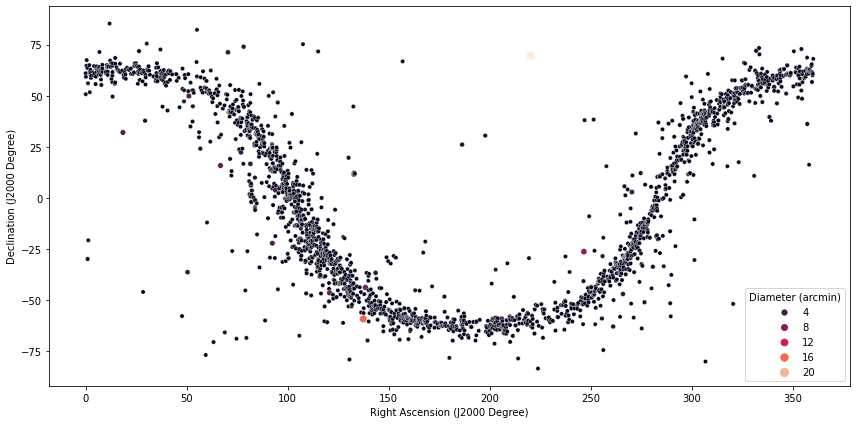

In [3]:
openclust_df = OpenClust.catalogue(as_dataframe=True)
fig, ax, g = cplt.plot_clusters_catalogue_distribution(openclust_df)
cplt.save_figure(fig, name='openclust_catalogue', save_dir=figures_save_dir)

## Cluster selection criteria

- diameter > 25.0 arcmin
- abs(parallax) > 0.0
- Number of stars in cluster without null values > 40.000

In [4]:
## Minimun cluster diamater
diam_cut = u.Quantity(25.0, u.arcmin)

## Minimun number of stars in cluster
nstars_cut = 40_000

## Required columns
required_columns = [
    "ra", "dec", "pmra", "pmdec", "parallax", "phot_g_mean_mag", "bp_rp"
]

## Clusters selection

In [5]:
open_clusters = OpenClust.catalogue()
selected_clusters = list()

for cluster in open_clusters.values():
    if cluster.diam >= diam_cut:
        try:
            cluster_stars = db.get_stars(region=cluster, columns=['parallax'], filter_null_columns=required_columns)
            cluster_stars = cluster_stars[np.abs(cluster_stars['parallax']) > 0.0]
            if len(cluster_stars) >= nstars_cut:
                selected_clusters.append({
                    "name": cluster.name,
                    "number_of_stars": len(cluster_stars)
                    })
        except Exception as error:
            pass

selected_clusters.sort(key=lambda cluster: cluster['number_of_stars'])

In [6]:
# Save results
file_name = "data/cluster_selection_tier1.json"
with open(file_name, "w") as f:
    f.write(json.dumps(selected_clusters))

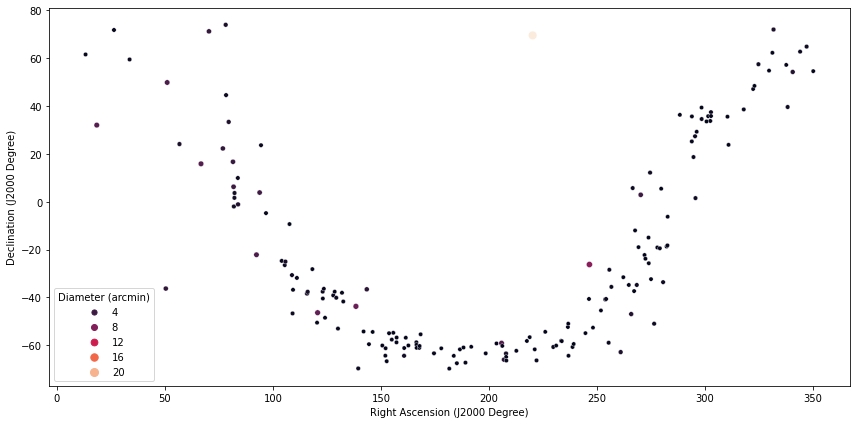

In [7]:
mask = openclust_df.index.isin(list(map(lambda x: x['name'], selected_clusters)))

fig, ax, g = cplt.plot_clusters_catalogue_distribution(openclust_df[mask])
cplt.save_figure(fig, name='cluster_selection_tier1', save_dir=figures_save_dir)

## Clusters preview

This section studies some of the main parameters for a small cluster selection

In [8]:
clusters_name = {'Melotte 22', 'NGC 6494'}
clusters = OpenClust.get_clusters(names=clusters_name)

### Melotte 22

In [9]:
melotte22 = clusters["Melotte 22"]
df_melotte22 = db.get_stars(region=melotte22)

melotte22_csv = pd.read_csv('data/MELOTTE22.csv')
df_melotte22['cluster_g'] = df_melotte22.index.get_level_values('source_id').isin(melotte22_csv.source_id)
df_melotte22['cluster_g'] = df_melotte22['cluster_g'].replace({True: "g1", False: "g0"})

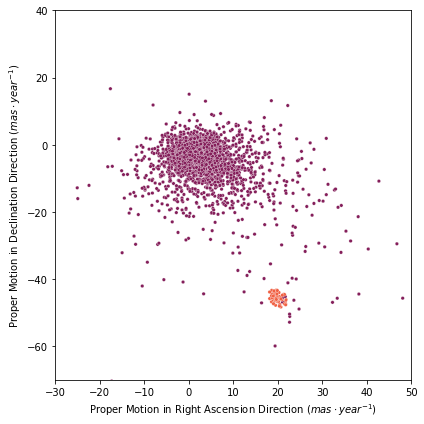

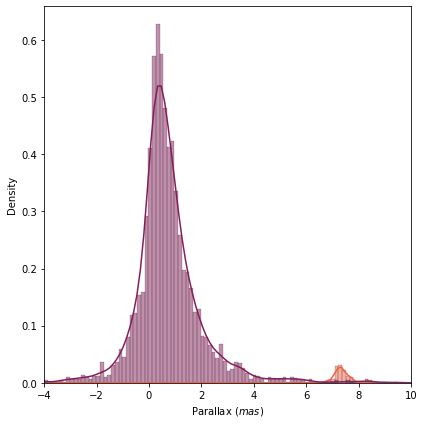

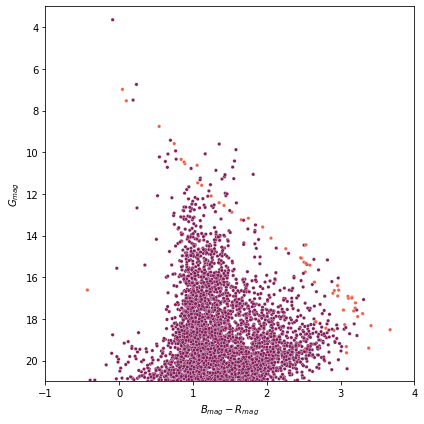

In [10]:
# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_melotte22, xlim=(-30, 50), ylim=(-70, 40), legend=False)
cplt.save_figure(fig, name=f"pm_{melotte22.name}", save_dir=f"{figures_save_dir}/melotte_22")

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_melotte22, xlim=(-4, 10), stat='density', legend=False)
cplt.save_figure(fig, name=f"parallax_{melotte22.name}", save_dir=f"{figures_save_dir}/melotte_22")

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_melotte22, xlim=(-1, 4), ylim=(3, 21), legend=False)
cplt.save_figure(fig, name=f"hr_diagram_{melotte22.name}", save_dir=f"{figures_save_dir}/melotte_22")

## NGC 6494

In [11]:
ngc6494 = clusters["NGC 6494"]
df_ngc6494 = db.get_stars(region=ngc6494)

ngc6494_csv = pd.read_csv('data/NGC6494.csv')
df_ngc6494['cluster_g'] = df_ngc6494.index.get_level_values('source_id').isin(ngc6494_csv.source_id)
df_ngc6494['cluster_g'] = df_ngc6494['cluster_g'].replace({True: "g1", False: "g0"})

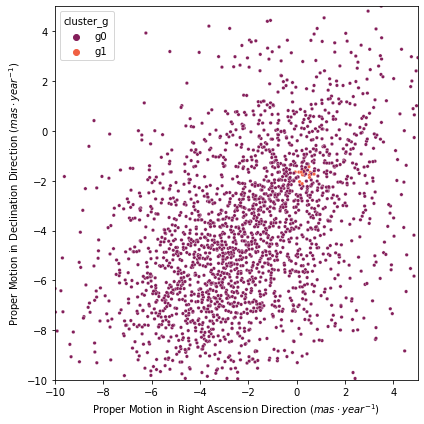

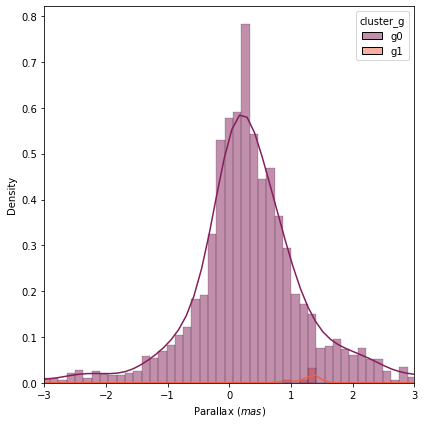

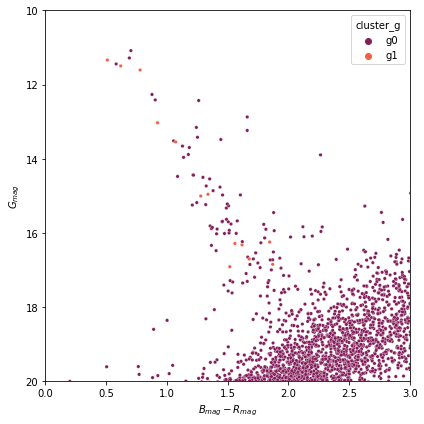

In [12]:
# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_ngc6494, xlim=(-10, 5), ylim=(-10, 5))
cplt.save_figure(fig, name=f"pm_{ngc6494.name}", save_dir=f"{figures_save_dir}/ngc_6494")

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_ngc6494, xlim=(-3, 3), stat='density')
cplt.save_figure(fig, name=f"parallax_{ngc6494.name}", save_dir=f"{figures_save_dir}/ngc_6494")

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_ngc6494, xlim=(0, 3), ylim=(10, 20))
cplt.save_figure(fig, name=f"hr_diagram_{ngc6494.name}", save_dir=f"{figures_save_dir}/ngc_6494")